In [16]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt




import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f_hcKCR1')
sess_df = pd.read_csv(basedir / 'sessions.csv')
# sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f_hckcr1')
figfolder.mkdir(parents=True, exist_ok=True)

Index(['date', 'fly', 'sess', 'condition', 'scan_type', 'usable', 'notes'], dtype='object')


In [18]:
sess_df.iloc[-5:]

date   fly              sess condition     scan_type  usable notes  \
105  27_05_2025  fly3      baseline-000       exp      baseline       1   NaN   
106  27_05_2025  fly3  remap_180deg-001       exp  remap_180deg       1   NaN   
107  27_05_2025  fly3   post_180deg-002       exp   post_180deg       1   NaN   
108  27_05_2025  fly3    remap_0deg-003       exp    remap_0deg       1   NaN   
109  27_05_2025  fly3     post_0deg-004       exp     post_0deg       1   NaN   

                  fly_id  mean offset  offset var.  mean vec. len  
105  27_05_2025_fly3_exp          NaN          NaN            NaN  
106  27_05_2025_fly3_exp          NaN          NaN            NaN  
107  27_05_2025_fly3_exp          NaN          NaN            NaN  
108  27_05_2025_fly3_exp          NaN          NaN            NaN  
109  27_05_2025_fly3_exp          NaN          NaN            NaN

In [19]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [20]:
opto_responses = {
    'remap': {'remap_0deg': [], 'remap_180deg': [], 'combined':[]}, 
    'no_chrimson': {'remap_0deg': [], 'remap_180deg': [], 'combined': []}, 
}

##
sess_df_remap0 = sess_df.loc[sess_df['scan_type']=='remap_0deg']
remap = sess_df_remap0.loc[sess_df_remap0['condition']=='exp']
opto_responses['remap']['remap_0deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in remap.iterrows()])

no_chrimson = sess_df_remap0.loc[sess_df_remap0['condition']=='no_cschrimson']
opto_responses['no_chrimson']['remap_0deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in no_chrimson.iterrows()]) 

##
sess_df_remap180 = sess_df.loc[sess_df['scan_type']=='remap_180deg']
remap = sess_df_remap180.loc[sess_df_remap180['condition']=='exp']
opto_responses['remap']['remap_180deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in remap.iterrows()])

no_chrimson = sess_df_remap180.loc[sess_df_remap180['condition']=='no_cschrimson']
opto_responses['no_chrimson']['remap_180deg'] = np.stack([nmp.remapping.get_opto_resp(load_row(row)) for _, row in no_chrimson.iterrows()]) 

opto_responses['remap']['combined'] = (opto_responses['remap']['remap_0deg'] + opto_responses['remap']['remap_180deg'])/2
opto_responses['no_chrimson']['combined'] = (opto_responses['no_chrimson']['remap_0deg'] + opto_responses['no_chrimson']['remap_180deg'])/2



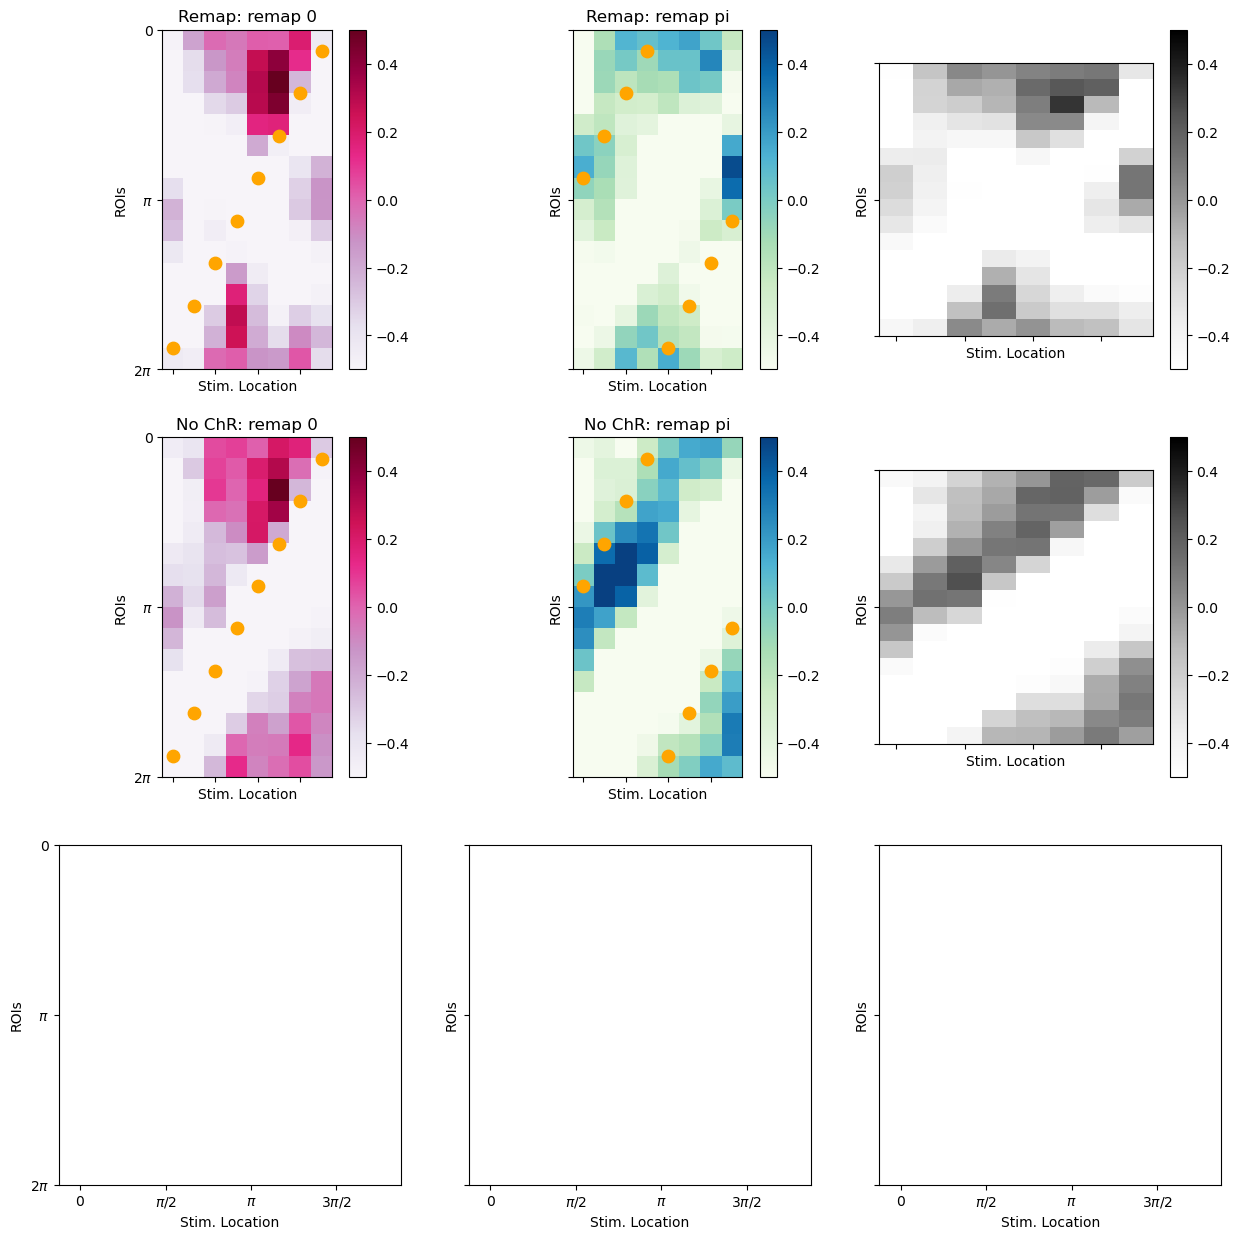

In [21]:
fig, ax = plt.subplots(3,3,figsize=[15,15],sharex=True,sharey=True)
h = ax[0,0].imshow(np.nanmean(opto_responses['remap']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(np.nanmean(opto_responses['remap']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[0,1])
h = ax[0,2].imshow(np.nanmean(opto_responses['remap']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[0,2])

ax[0, 0].set_title('Remap: remap 0')
ax[0, 1].set_title('Remap: remap pi')



h = ax[1,0].imshow(np.nanmean(opto_responses['no_chrimson']['remap_0deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(np.nanmean(opto_responses['no_chrimson']['remap_180deg'],axis=(0,3)),aspect=1, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[1,1])
h = ax[1,2].imshow(np.nanmean(opto_responses['no_chrimson']['combined'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[1,2])

ax[1, 0].set_title('No ChR: remap 0')
ax[1, 1].set_title('No ChR: remap pi')



for r in range(2):
    x = np.arange(8)
    y = np.arange(0,2*np.pi,np.pi/4)[::-1]*8/np.pi+.5
    h = ax[r,0].scatter(x,y,color= 'orange',s=80)


    y = np.roll(y,4)
    ax[r,1].scatter(x,y,color='orange',s=80)
    

for a in ax.flatten():
    a.set_ylabel('ROIs')
    a.set_xlabel('Stim. Location')
    
    a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])


In [22]:
opto_resp_al = {}
for ck in ('remap', 'no_chrimson'):
    opto_resp_al[ck] = {}
    for rk in opto_responses[ck].keys():
        opto = np.copy(opto_responses[ck][rk])
        for i in range(8):
            opto[:,:,i,:] = np.roll(opto[:,:,i,:],2*i-8, axis=1)
            
        opto_resp_al[ck][rk] = opto

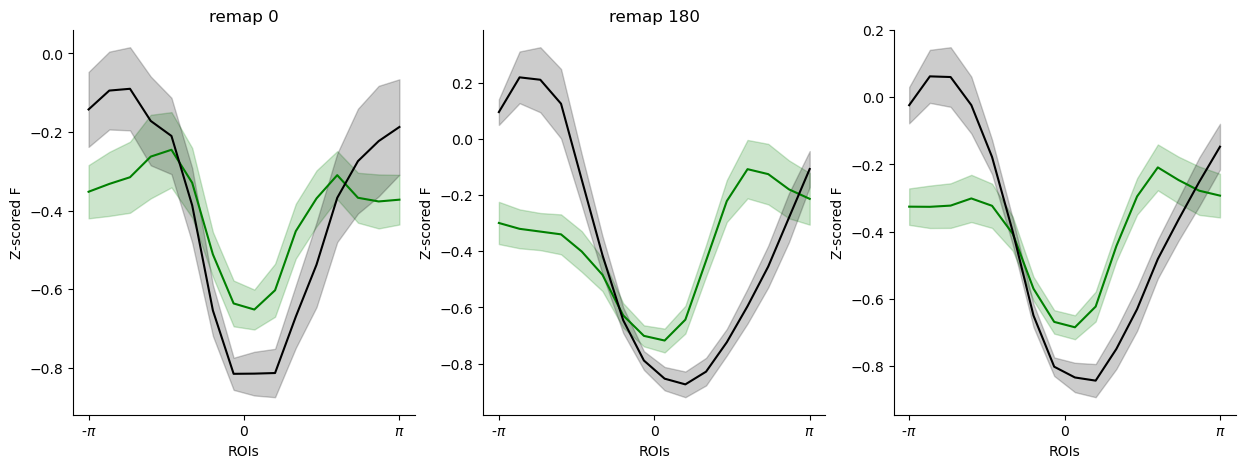

In [23]:
fig, ax = plt.subplots(1,3, figsize=[15,5])
x = np.linspace(-np.pi, np.pi, num=16)

remap_resp = opto_resp_al['remap']['remap_0deg'].mean(axis=(2,3))
nochrimson_resp = opto_resp_al['no_chrimson']['remap_0deg'].mean(axis=(2,3))

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[0].plot(x, mu, color='green')
ax[0].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[0].plot(x, mu, color='black')
ax[0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

ax[0].set_title('remap 0')

remap_resp = opto_resp_al['remap']['remap_180deg'].mean(axis=(2,3))
nochrimson_resp = opto_resp_al['no_chrimson']['remap_180deg'].mean(axis=(2,3))

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[1].plot(x, mu, color='green')
ax[1].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[1].plot(x, mu, color='black')
ax[1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

ax[1].set_title('remap 180')

remap_resp = np.stack((opto_resp_al['remap']['remap_0deg'].mean(axis=(2,3)), opto_resp_al['remap']['remap_180deg'].mean(axis=(2,3)))).mean(axis=0)
nochrimson_resp = np.stack((opto_resp_al['no_chrimson']['remap_0deg'].mean(axis=(2,3)), opto_resp_al['no_chrimson']['remap_180deg'].mean(axis=(2,3)))).mean(axis=0)

mu, sem = remap_resp.mean(axis=0), sp.stats.sem(remap_resp, axis=0)
ax[2].plot(x, mu, color='green', label='remap')
ax[2].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

mu, sem = nochrimson_resp.mean(axis=0), sp.stats.sem(nochrimson_resp, axis=0)
ax[2].plot(x, mu, color='black', label='no chrimson')
ax[2].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)



#


for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    a.set_ylabel('Z-scored F')
    a.set_xlabel('ROIs')

    _ = a.set_xticks([-np.pi, 0, np.pi], labels = [r'-$\pi$', '0', r'$\pi$'])

# fig.savefig( figfolder / "aligned_opto_resp.pdf")

In [24]:
# nonremap_sess_df = sess_df.loc[(sess_df['scan_type']=='baseline') | \
#                                (sess_df['scan_type']=='post_0deg') | \
#                                (sess_df['scan_type']=='post_180deg')]
flies = sess_df['fly_id'].unique()
for index,row in sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    
    
    offset_c_mu = ts.offset_c.mean()
    
    sess_df.loc[index, 'mean offset'] = np.angle(offset_c_mu)
    sess_df.loc[index, 'mean vec. len'] = np.abs(offset_c_mu)
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(ts.offset)

In [25]:
def build_sum_stats(fly_list):
    sum_stats = {'fly_id': []}
    if not 'novis' in fly_list[0]:
        for s in ('baseline', 'post_0deg', 'post_180deg'):
            sum_stats[f'{s} mean offset'] = []
            sum_stats[f'{s} vec. len'] = []
            sum_stats[f'{s} offset var.'] = []
            
    else:
            
        for s in ('baseline', 'post_novis1', 'post_novis2'):
            sum_stats[f'{s} mean offset'] = []
            sum_stats[f'{s} vec. len'] = []
            sum_stats[f'{s} offset var.'] = []
                
    
    
    
    for fly in fly_list:
        sum_stats['fly_id'].append(fly)
        
        if not 'novis' in fly:
            for s in ('baseline', 'post_0deg', 'post_180deg'):
                sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
        else:
            for s in ('baseline', 'post_novis1', 'post_novis2'):
                sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
                sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
                sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
    return pd.DataFrame(sum_stats)                
        
    

In [26]:
remap_flies = [fly for fly in flies if 'exp' in fly]
remap_sum_stats = build_sum_stats(remap_flies)

nochrimson_flies = [fly for fly in flies if 'no_cschrimson' in fly]
nochrimson_sum_stats = build_sum_stats(nochrimson_flies)


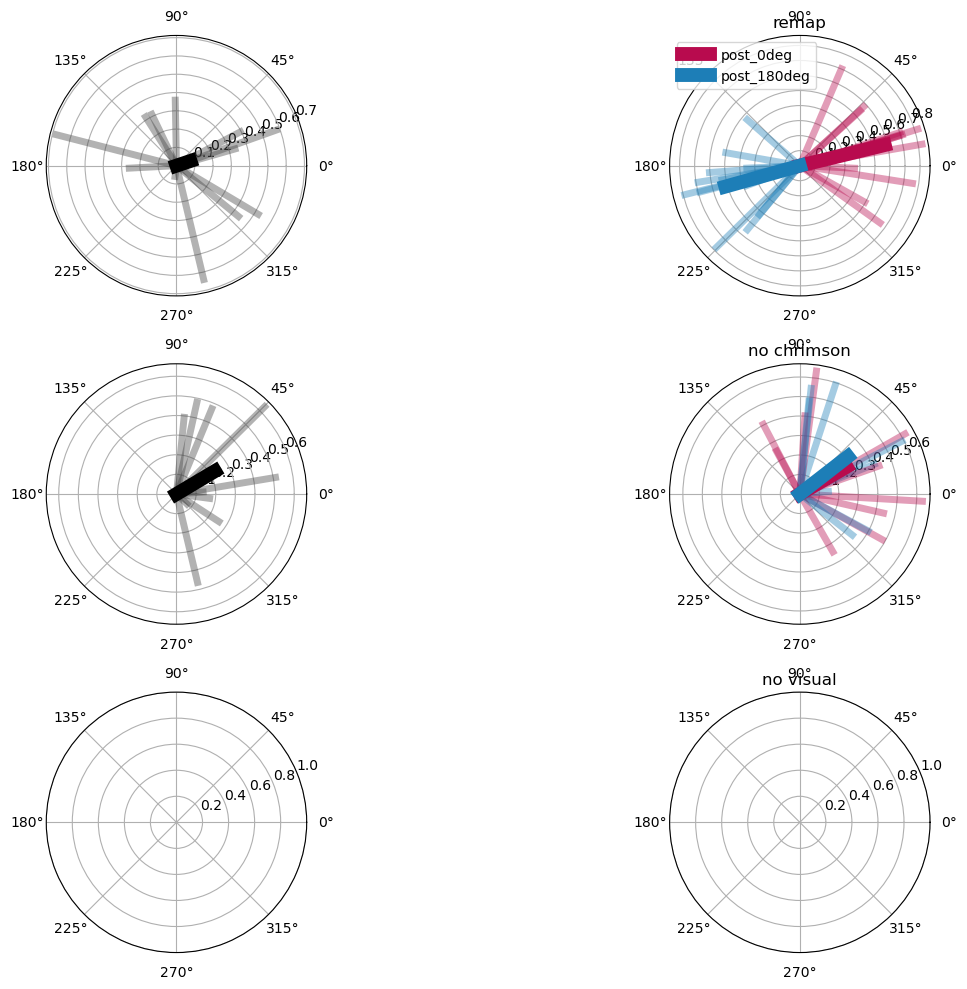

In [27]:
fig, ax = plt.subplots(3, 2, subplot_kw={'projection':'polar'}, figsize=[15,10])

for _, row in remap_sum_stats.iterrows():
    ax[0,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
    
    ax[0,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=5)
    ax[0,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=5)

baseline_v = remap_sum_stats['baseline vec. len']*(np.cos(remap_sum_stats['baseline mean offset'])+1j*np.sin(remap_sum_stats['baseline mean offset']))
ax[0,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

post_0deg_v = remap_sum_stats['post_0deg vec. len']*(np.cos(remap_sum_stats['post_0deg mean offset'])+1j*np.sin(remap_sum_stats['post_0deg mean offset']))
ax[0,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=10, label='post_0deg')

post_180deg_v = remap_sum_stats['post_180deg vec. len']*(np.cos(remap_sum_stats['post_180deg mean offset'])+1j*np.sin(remap_sum_stats['post_180deg mean offset']))
ax[0,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
             color=plt.cm.GnBu(.8), linewidth=10, label='post_180deg')

ax[0,1].legend()


##
for _, row in nochrimson_sum_stats.iterrows():
    ax[1, 0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=5)
    
    ax[1, 1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=5)
    ax[1, 1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=5)

baseline_v = nochrimson_sum_stats['baseline vec. len']*(np.cos(nochrimson_sum_stats['baseline mean offset'])+1j*np.sin(nochrimson_sum_stats['baseline mean offset']))
ax[1, 0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=10)

post_0deg_v = nochrimson_sum_stats['post_0deg vec. len']*(np.cos(nochrimson_sum_stats['post_0deg mean offset'])+1j*np.sin(nochrimson_sum_stats['post_0deg mean offset']))
ax[1,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=10, label='post_0deg')

post_180deg_v = nochrimson_sum_stats['post_180deg vec. len']*(np.cos(nochrimson_sum_stats['post_180deg mean offset'])+1j*np.sin(nochrimson_sum_stats['post_180deg mean offset']))
ax[1,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
             color=plt.cm.GnBu(.8), linewidth=10, label='post_180deg')



ax[0,1].set_title('remap')
ax[1,1].set_title('no chrimson')
ax[2,1].set_title('no visual')


fig.tight_layout()

# fig.savefig(figfolder / "remapping_all_flies_polar.pdf")

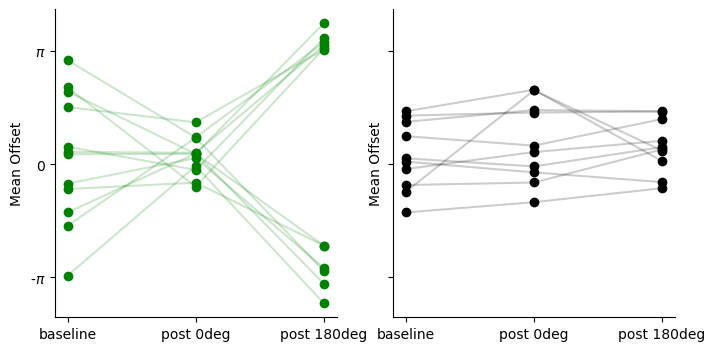

In [28]:
fig, ax = plt.subplots(1,2, figsize=[8,4], sharex=True, sharey=True)
nmp.remapping.plot_min_dist(remap_sum_stats, ax[0], color='green')

nmp.remapping.plot_min_dist(nochrimson_sum_stats, ax[1], color='black', zero=True)

# ax[1].set_title('')

for a in ax.flatten():
    a.set_xticks([0,1,2], ['baseline', 'post 0deg', 'post 180deg'])
    a.set_yticks([-np.pi,0,np.pi], [r'-$\pi$', '0', r'$\pi$'])
    a.set_ylabel('Mean Offset')
    
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

fig.savefig(figfolder / "remapping_all_flies.pdf")

In [29]:
def avg_diff(sum_stats):
    if not 'post_novis1 mean offset' in sum_stats.columns:
        diff0 = np.abs(sum_stats['post_0deg mean offset'] )
        diff180 = np.abs(np.pi - sum_stats['post_180deg mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)
        
        
        
    else:
        diff0 = np.abs(sum_stats['post_novis1 mean offset'])
        diff0 = np.minimum(diff0, 2*np.pi-diff0)
        
        diff180 = np.abs(np.pi - sum_stats['post_novis2 mean offset'] )
        diff180 = np.minimum(diff180, 2*np.pi-diff180)
                
    return (diff0+diff180)/2

remap error less than chance: t=0.0, p=0.00048828125
no chrimson error less than chance: t=25.0, p=0.845703125
remap diff than no chrimson: t=0.0, p=8.733926588357827e-05


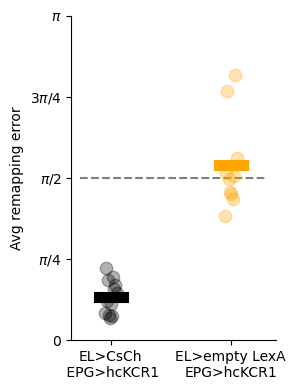

In [31]:
fig, ax = plt.subplots(figsize=[3,4])

remap_avg_diff = avg_diff(remap_sum_stats)
n_remap = remap_avg_diff.shape[0]
ax.scatter(np.linspace(0,.1,num=n_remap), remap_avg_diff, color='black', alpha=.3, s=80)
ax.plot([-.05,.15], remap_avg_diff.mean()*np.ones([2,]), color='black', linewidth=8)

nochrimson_avg_diff = avg_diff(nochrimson_sum_stats)
n_nochrimson = nochrimson_avg_diff.shape[0]
ax.scatter(np.linspace(0,.1,num=n_nochrimson)+1, nochrimson_avg_diff, color='orange', alpha=.3, s=80)
ax.plot([.95,1.15], nochrimson_avg_diff.mean()*np.ones([2,]), color='orange', linewidth=8)






ax.plot([-.2,1.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1)

ax.set_xticks([.05,1.05], labels=['EL>CsCh\n EPG>hcKCR1', 'EL>empty LexA\nEPG>hcKCR1'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg remapping error')
_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])

fig.tight_layout()


t, p = sp.stats.wilcoxon(remap_avg_diff - np.pi/2)
print(f"remap error less than chance: t={t}, p={p}")

nochrimson_avg_diff = nochrimson_avg_diff[~np.isnan(nochrimson_avg_diff)]
t, p = sp.stats.wilcoxon(nochrimson_avg_diff - np.pi/2)
print(f"no chrimson error less than chance: t={t}, p={p}")



t, p = sp.stats.mannwhitneyu(remap_avg_diff, nochrimson_avg_diff)
print(f"remap diff than no chrimson: t={t}, p={p}")


fig.savefig(figfolder / "remapping_error.pdf")
